In [8]:
ls

Complex-data-health/        Stock_Market_TS_Prediction/
Curso2023-2024-ODKG/        cloud-2324/
Massively-Parallel-ML/


In [9]:
cd Stock_Market_TS_Prediction


/Users/nicolacecere/GitHub/UPM-Master/Stock_Market_TS_Prediction


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# from scripts.utils import add_seasonality
from sklearn.preprocessing import StandardScaler


def create_sequences(data, t):
    X_train, y_train = [], []
    i = 0
    while i + 2 * t <= len(data):  # Ensure enough data for both X_train and y_train
        X_train.append(data.iloc[i : i + t, :].values)
        y_train.append(data.iloc[i + t : i + t + t]["Close"].values)
        i += t
    return np.array(X_train), np.array(y_train)


load_dotenv()

df = pd.read_csv("data/sp500/csv/AAPL.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.drop(columns=["Date", "Adjusted Close"], inplace=True)

# df = add_seasonality(df)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]

scaler = StandardScaler()
scaler.fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

# Create sequences of t timesteps with d dimensions
t = 21 
X_train, y_train = create_sequences(train, t)
X_test, y_test = create_sequences(test, t)

# X_train is shaped as [samples, time steps, features]
# y_train is shaped as [samples, t labels]

/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nicolacecere/opt/anaconda3/envs/DMTS/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_

Epoch 1/50
846/846 [==============================] - 3s 2ms/step - loss: 33.0783
Epoch 2/50
846/846 [==============================] - 2s 2ms/step - loss: 30.2320
Epoch 3/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9528
Epoch 4/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9174
Epoch 5/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9299
Epoch 6/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9269
Epoch 7/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9190
Epoch 8/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9159
Epoch 9/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9163
Epoch 10/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9175
Epoch 11/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9118
Epoch 12/50
846/846 [==============================] - 2s 2ms/step - loss: 29.9216
Epoch 13/50
8

In [ ]:
model = Sequential()
model.add(
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]))
)  # Adjusted for dynamic input shape
model.add(Dense(t))  # Output layer with 't' units, one for each label

model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_LSTM_regressor(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(512, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(512)(lstm)
    dropout = tfkl.Dropout(.5)(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dropout)  # No activation for regression

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='LSTM_regressor')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = t  # Number of days to predict

# Build and compile the model
model = build_LSTM_regressor(input_shape, output_units)
model.summary()

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=1,  # Adjust if needed
    epochs=50,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Model: "LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10, 8)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 512)           1067008   
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 3171338 (12.10 MB)
Trainable params: 3171338 (12.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7

KeyboardInterrupt: 

In [23]:

test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss}")

7/7 [==============================] - 0s 3ms/step - loss: 6871.2524
Test Loss (Mean Squared Error): 6871.25244140625


7/7 [==============================] - 0s 2ms/step


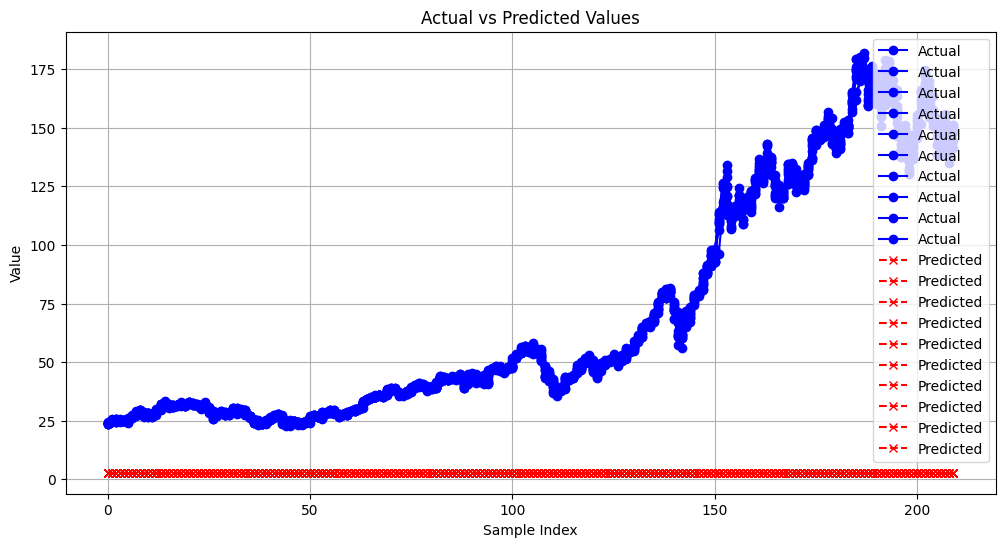

In [24]:
y_pred = model.predict(X_test)
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="blue", marker="o")
plt.plot(
    y_pred, label="Predicted", color="red", linestyle="dashed", marker="x"
)
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
X_test.shape

(99, 21, 8)

In [21]:
y_pred.shape

(99, 21)